In [1]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from torch.nn import Transformer
import torch.nn.functional as F
from torch import Tensor
from torch import nn
from tqdm import tqdm
from torch import optim
import warnings
import random
import torch
import math
import yaml
import json
import os
import numpy as np
import string
# warnings.filterwarnings("ignore")

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 3080 , device num:0


In [3]:
def metrics(pred:list, target:list) -> float:
    """
    pred: list of strings
    target: list of strings

    return: accuracy(%)
    """
    if len(pred) != len(target):
        raise ValueError('length of pred and target must be the same')
    correct = 0
    for i in range(len(pred)):
        if pred[i] == target[i]:
            correct += 1
    return correct / len(pred) * 100

In [4]:
#compute BLEU-4 score
reference = 'variable'
output = 'varable'

def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

In [5]:
SOS_token = 0
EOS_token = 1
PAD_token = 2
embedding_num = 29
embedding_dim = 512
num_layers = 8
num_heads = 8
ff_dim = 1024
dropout = 0.1
hidden_size = 512

ce_loss = nn.CrossEntropyLoss(ignore_index=2)

In [6]:
characters = ['SOS']+['EOS','PAD']+[chr(i)for i in range(ord('a'),ord('z')+1)]
char_to_index = {char: a for a, char in enumerate(characters)}
index_to_char = {i: char for i, char in enumerate(characters)}
def index_to_word_sequence(lis, index_to_char, remove_token=True):
    if remove_token:
        lis = "".join([index_to_char[char] for char in lis]).split('EOS')[0].replace('SOS', '')
        return lis
    else:
        return [index_to_char[char] for char in lis]

In [7]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000, batch_first: bool = False):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        self.batch_first = batch_first

    def forward(self, x: Tensor) -> Tensor:
        if self.batch_first:
            x = x.transpose(0, 1)
            x = x + self.pe[:x.size(0)]
            return self.dropout(x.transpose(0, 1))
        else:
            x = x + self.pe[:x.size(0)]
            return self.dropout(x)

In [8]:
class SpellCorrectionDataset(Dataset):
    def __init__(self,data,targets):
        super(SpellCorrectionDataset, self).__init__()
        
        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = torch.tensor(self.data[index],dtype=torch.long)
        y = torch.tensor(self.targets[index],dtype=torch.long)
        return x,y

In [9]:
file_path ='train.json'
with open(file_path, 'r') as file:
            data = json.load(file)
target_list = []
input_list = []
for i in range(len(data)):
    for j in range(len(data[i]['input'])):
        input_list.append(data[i]['input'][j])
        target_list.append(data[i]['target'])
# 字母到數字
letter_to_number = {char: i + 3 for i, char in enumerate(string.ascii_lowercase)}
# 單字到數字
word_to_number = {word: [letter_to_number[char] for char in word] for word in input_list}
# 進行轉換
input_list = [word_to_number[word] for word in input_list]
# 進行padding
input_list = [[SOS_token] + arr for arr in input_list]
input_list = [arr + [EOS_token] for arr in input_list]
input_list = [arr + [PAD_token] * (22-len(arr))for arr in input_list]
# 單字到數字
word_to_number = {word: [letter_to_number[char] for char in word] for word in target_list}
# 進行轉換
target_list = [word_to_number[word] for word in target_list]
# 進行padding
target_list = [[SOS_token] + arr for arr in target_list]
target_list = [arr + [EOS_token] for arr in target_list]
target_list = [arr + [PAD_token] * (22-len(arr))for arr in target_list]

train_X = input_list
train_Y = target_list

In [10]:
file_path ='test.json'
with open(file_path, 'r') as file:
            data = json.load(file)
target_list = []
input_list = []
for i in range(len(data)):
    for j in range(len(data[i]['input'])):
        input_list.append(data[i]['input'][j])
        target_list.append(data[i]['target'])
# 字母到數字
letter_to_number = {char: i + 3 for i, char in enumerate(string.ascii_lowercase)}
# 單字到數字
word_to_number = {word: [letter_to_number[char] for char in word] for word in input_list}
# 進行轉換
input_list = [word_to_number[word] for word in input_list]
# 進行padding
input_list = [[SOS_token] + arr for arr in input_list]
input_list = [arr + [EOS_token] for arr in input_list]
input_list = [arr + [PAD_token] * (22-len(arr))for arr in input_list]
# 單字到數字
word_to_number = {word: [letter_to_number[char] for char in word] for word in target_list}
# 進行轉換
target_list = [word_to_number[word] for word in target_list]
# 進行padding
target_list = [[SOS_token] + arr for arr in target_list]
target_list = [arr + [EOS_token] for arr in target_list]
target_list = [arr + [PAD_token] * (22-len(arr))for arr in target_list]

test_X = input_list
test_Y = target_list

In [11]:
file_path ='new_test.json'
with open(file_path, 'r') as file:
            data = json.load(file)
target_list = []
input_list = []
for i in range(len(data)):
    for j in range(len(data[i]['input'])):
        input_list.append(data[i]['input'][j])
        target_list.append(data[i]['target'])
# 字母到數字
letter_to_number = {char: i + 3 for i, char in enumerate(string.ascii_lowercase)}
# 單字到數字
word_to_number = {word: [letter_to_number[char] for char in word] for word in input_list}
# 進行轉換
input_list = [word_to_number[word] for word in input_list]
# 進行padding
input_list = [[SOS_token] + arr for arr in input_list]
input_list = [arr + [EOS_token] for arr in input_list]
input_list = [arr + [PAD_token] * (22-len(arr))for arr in input_list]
# 單字到數字
word_to_number = {word: [letter_to_number[char] for char in word] for word in target_list}
# 進行轉換
target_list = [word_to_number[word] for word in target_list]
# 進行padding
target_list = [[SOS_token] + arr for arr in target_list]
target_list = [arr + [EOS_token] for arr in target_list]
target_list = [arr + [PAD_token] * (22-len(arr))for arr in target_list]

new_test_X = input_list
new_test_Y = target_list

In [12]:
trainset = SpellCorrectionDataset(train_X,train_Y)
trainloader = DataLoader(trainset, batch_size=16,shuffle=True)
valset = SpellCorrectionDataset(test_X,test_Y)
valloader = DataLoader(valset, batch_size=16,shuffle=False)
testset = SpellCorrectionDataset(new_test_X,new_test_Y)
testloader = DataLoader(testset, batch_size=16,shuffle=False)

In [13]:
class Encoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length=100):
        super(Encoder, self).__init__()
        self.tok_embedding = nn.Embedding(num_emb, hid_dim)
        self.pos_embedding = PositionalEncoding(hid_dim, dropout, max_length, batch_first=True)
        self.layer = TransformerEncoderLayer(hid_dim, n_heads, ff_dim, dropout, batch_first=True, norm_first=True)
        self.encoder = TransformerEncoder(self.layer,  n_layers)

    def forward(self, src, src_pad_mask):
        src = self.tok_embedding(src)
        src = self.pos_embedding(src)
        src = self.encoder(src, src_key_padding_mask=src_pad_mask)
        return src

class Decoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length=100):
        super(Decoder, self).__init__()
        self.tok_embedding = nn.Embedding(num_emb, hid_dim)
        self.pos_embedding = PositionalEncoding(hid_dim, dropout, max_length, batch_first=True)
        # self.layer = <nn.TransformerDecoderLayer>
        # self.encoder = <nn.TransformerDecoder>
        self.layer = TransformerDecoderLayer(hid_dim, n_heads, ff_dim, dropout, activation='relu', batch_first=True, norm_first=True)
        self.decoder = TransformerDecoder(self.layer, n_layers)
        self.linear = nn.Linear(hid_dim, num_emb)

    def forward(self, tgt, memory, tgt_mask, tgt_pad_mask, src_pad_mask):
        # tgt = your_embeddings(?)
        # tgt = self.decoder(?)
        tgt = self.tok_embedding(tgt)
        tgt = self.pos_embedding(tgt)
        tgt = self.decoder(tgt, memory=memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_pad_mask, memory_key_padding_mask=src_pad_mask)
        tgt = self.linear(tgt)
        return tgt

class TransformerAutoEncoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length=100, encoder=None):
        super(TransformerAutoEncoder, self).__init__()
        if encoder is None:
            self.encoder = Encoder(num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length)
        else:
            self.encoder = encoder
        self.decoder = Decoder(num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length)

    def forward(self, src, tgt, src_pad_mask, tgt_mask, tgt_pad_mask):
        enc_src = self.encoder(src, src_pad_mask)
        out = self.decoder(tgt, enc_src, tgt_mask, tgt_pad_mask, src_pad_mask)
        return out

In [14]:
def gen_padding_mask(src, pad_idx):
    pad_mask = (src == pad_idx)
    return pad_mask

def gen_mask(seq):
    mask_shape = seq, seq
    att_mask = torch.triu(torch.ones(mask_shape), diagonal=1).bool()
    #print('att:', att_mask.shape)
    return att_mask

def get_index(pred, dim=2):
    return pred.clone().argmax(dim=dim)

# Train our spelling correction transformer

In [15]:
def validation(dataloader, model, device, logout=False):
    pred_str_list = []
    tgt_str_list = []
    input_str_list = []
    Bleu_score = []
    losses = []
    model.eval()
    for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = torch.ones_like(tgt) * 2 #An all pad token tensor with the same shape as tgt and the first token is <sos>
            tgt_input[:, 0] = 0 
            for i in range(tgt.shape[1]-1):
                src_pad_mask = gen_padding_mask(src, pad_idx=2).to(device)
                tgt_pad_mask = gen_padding_mask(tgt_input, pad_idx=2).to(device)
                tgt_mask = gen_mask(tgt_input.size(1)).to(device)
                pred = model(src, tgt_input, src_pad_mask, tgt_mask, tgt_pad_mask)
                tgt_input[:, i + 1] = get_index(pred)[:, i]
            for i in range (tgt.shape[0]):
                pred_str_list.append(index_to_word_sequence(tgt_input[i].tolist(), index_to_char))
                tgt_str_list.append(index_to_word_sequence(tgt[i].tolist(), index_to_char))
                input_str_list.append(index_to_word_sequence(src[i].tolist(), index_to_char))
                if logout:
                    print('='*30)
                    print(f'input: {input_str_list[-1]}')
                    print(f'pred: {pred_str_list[-1]}')
                    print(f'target: {tgt_str_list[-1]}')
            loss = ce_loss(pred[:, :-1, :].permute(0, 2, 1), tgt[:, 1:])
            losses.append(loss.item())

    for v in range(len(input_str_list)):
        Bleu_score.append(compute_bleu(pred_str_list[v], tgt_str_list[v]))
    
    model.train()
    
    acc = metrics(pred_str_list, tgt_str_list)
    total_loss = sum(losses)/len(losses)
    bleu_score = np.mean(Bleu_score)
    print(f"New_test_acc: {acc:.2f}", f"New_test_loss: {total_loss:.2f}", f"New_bleu_score: {bleu_score:.3f}", end=' | ')
    #print(f"New_test_pred: {pred_str_list} ,New_test_target: {tgt_str_list}]")
    return acc, total_loss, bleu_score

In [16]:
def validation2(dataloader, model, device, logout=False):
    pred_str_list = []
    tgt_str_list = []
    input_str_list = []
    Bleu_score = []
    losses = []
    model.eval()
    for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = torch.ones_like(tgt) * 2 
            tgt_input[:, 0] = 0 
            for i in range(tgt.shape[1]-1):
                src_pad_mask = gen_padding_mask(src, pad_idx=2).to(device)
                tgt_pad_mask = gen_padding_mask(tgt_input, pad_idx=2).to(device)
                tgt_mask = gen_mask(tgt_input.size(1)).to(device)
                pred = model(src, tgt_input, src_pad_mask, tgt_mask, tgt_pad_mask)
                tgt_input[:, i + 1] = get_index(pred)[:, i]
            for i in range (tgt.shape[0]):
                pred_str_list.append(index_to_word_sequence(tgt_input[i].tolist(), index_to_char))
                tgt_str_list.append(index_to_word_sequence(tgt[i].tolist(), index_to_char))
                input_str_list.append(index_to_word_sequence(src[i].tolist(), index_to_char))
                if logout:
                    print('='*30)
                    print(f'input: {input_str_list[-1]}')
                    print(f'pred: {pred_str_list[-1]}')
                    print(f'target: {tgt_str_list[-1]}')
            loss = ce_loss(pred[:, :-1, :].permute(0, 2, 1), tgt[:, 1:])
            losses.append(loss.item())

    for v in range(len(input_str_list)):
        Bleu_score.append(compute_bleu(pred_str_list[v], tgt_str_list[v]))
    
    model.train()
    
    acc = metrics(pred_str_list, tgt_str_list)
    total_loss = sum(losses)/len(losses)
    bleu_score = np.mean(Bleu_score)
    print(f"Test_acc: {acc:.2f}", f"Test_loss: {total_loss:.2f}", f"Test_Bleu_score: {bleu_score:.3f}", end=' | ')
    #print(f"Test_Pred: {pred_str_list},Test_Target: {tgt_str_list}]")
    return acc, total_loss, bleu_score

In [17]:
model = TransformerAutoEncoder(embedding_num, embedding_dim, num_layers, num_heads, ff_dim, dropout).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200, 230], gamma=0.5)

In [18]:
EPOCHES = 250

train_losses = []

test_losses = []
test_accs = []
test_bleus = []

n_test_losses = []
n_test_accs = []
n_test_bleus = []

best_acc = 0
best_acc2 = 0

early_stop = 100
best_nt_loss = float('inf')
best_test_loss = float('inf')

for eps in range(EPOCHES):
    # train
    losses = []
    model.train()
    i_bar = tqdm(trainloader, unit='iter', desc=f'epoch{eps}')
    for src, tgt in i_bar:
        src, tgt = src.to(device), tgt.to(device)
        # generate the mask and padding mask
        src_pad_mask = gen_padding_mask(src, pad_idx=2).to(device)
        tgt_pad_mask = gen_padding_mask(tgt, pad_idx=2).to(device)
        tgt_mask = gen_mask(tgt.size(1)).to(device)

        optimizer.zero_grad()
        pred = model(src, tgt, src_pad_mask, tgt_mask, tgt_pad_mask)
        loss = ce_loss(pred[:, :-1, :].permute(0, 2, 1), tgt[:, 1:])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        i_bar.set_postfix_str(f"loss: {sum(losses)/len(losses):.3f}")
        
    total_loss = sum(losses)/len(losses)
    train_losses.append(total_loss)
    scheduler.step()

    # test
    model.eval()
    with torch.no_grad():
        test_acc,test_loss,test_bleu = validation2(valloader, model, device)
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    test_bleus.append(test_bleu)

    model.eval()
    with torch.no_grad():
        new_test_acc, new_test_loss, new_test_bleu = validation(testloader, model, device)
    n_test_accs.append(new_test_acc)
    n_test_losses.append(new_test_loss)
    n_test_bleus.append(new_test_bleu)

epoch0: 100%|██████████| 808/808 [00:56<00:00, 14.27iter/s, loss: 3.288] 


Test_acc: 2.00 Test_loss: 2.27 Test_Bleu_score: 0.295 | New_test_acc: 2.00 New_test_loss: 2.02 New_bleu_score: 0.249 | 

epoch1: 100%|██████████| 808/808 [00:53<00:00, 15.14iter/s, loss: 1.313]


Test_acc: 6.00 Test_loss: 1.83 Test_Bleu_score: 0.381 | New_test_acc: 2.00 New_test_loss: 1.57 New_bleu_score: 0.354 | 

epoch2: 100%|██████████| 808/808 [00:53<00:00, 15.10iter/s, loss: 1.119]


Test_acc: 6.00 Test_loss: 2.41 Test_Bleu_score: 0.445 | New_test_acc: 6.00 New_test_loss: 1.38 New_bleu_score: 0.466 | 

epoch3: 100%|██████████| 808/808 [00:53<00:00, 15.15iter/s, loss: 1.021]


Test_acc: 10.00 Test_loss: 2.24 Test_Bleu_score: 0.478 | New_test_acc: 8.00 New_test_loss: 1.50 New_bleu_score: 0.433 | 

epoch4: 100%|██████████| 808/808 [00:56<00:00, 14.36iter/s, loss: 0.958]


Test_acc: 6.00 Test_loss: 2.56 Test_Bleu_score: 0.493 | New_test_acc: 16.00 New_test_loss: 1.37 New_bleu_score: 0.509 | 

epoch5: 100%|██████████| 808/808 [00:54<00:00, 14.72iter/s, loss: 0.919]


Test_acc: 8.00 Test_loss: 2.29 Test_Bleu_score: 0.504 | New_test_acc: 10.00 New_test_loss: 1.28 New_bleu_score: 0.442 | 

epoch6: 100%|██████████| 808/808 [00:53<00:00, 15.14iter/s, loss: 0.884]


Test_acc: 12.00 Test_loss: 2.33 Test_Bleu_score: 0.527 | New_test_acc: 14.00 New_test_loss: 1.42 New_bleu_score: 0.512 | 

epoch7: 100%|██████████| 808/808 [00:52<00:00, 15.28iter/s, loss: 0.853]


Test_acc: 18.00 Test_loss: 2.13 Test_Bleu_score: 0.545 | New_test_acc: 12.00 New_test_loss: 1.23 New_bleu_score: 0.468 | 

epoch8: 100%|██████████| 808/808 [00:53<00:00, 15.07iter/s, loss: 0.827]


Test_acc: 10.00 Test_loss: 2.46 Test_Bleu_score: 0.510 | New_test_acc: 14.00 New_test_loss: 1.73 New_bleu_score: 0.461 | 

epoch9: 100%|██████████| 808/808 [00:51<00:00, 15.66iter/s, loss: 0.803]


Test_acc: 16.00 Test_loss: 2.38 Test_Bleu_score: 0.560 | New_test_acc: 16.00 New_test_loss: 1.26 New_bleu_score: 0.498 | 

epoch10: 100%|██████████| 808/808 [00:51<00:00, 15.60iter/s, loss: 0.780]


Test_acc: 22.00 Test_loss: 2.35 Test_Bleu_score: 0.575 | New_test_acc: 12.00 New_test_loss: 1.37 New_bleu_score: 0.464 | 

epoch11: 100%|██████████| 808/808 [00:52<00:00, 15.51iter/s, loss: 0.759]


Test_acc: 18.00 Test_loss: 2.37 Test_Bleu_score: 0.569 | New_test_acc: 16.00 New_test_loss: 1.28 New_bleu_score: 0.464 | 

epoch12: 100%|██████████| 808/808 [00:52<00:00, 15.26iter/s, loss: 0.743]


Test_acc: 24.00 Test_loss: 2.09 Test_Bleu_score: 0.577 | New_test_acc: 14.00 New_test_loss: 1.26 New_bleu_score: 0.471 | 

epoch13: 100%|██████████| 808/808 [00:53<00:00, 15.04iter/s, loss: 0.725]


Test_acc: 28.00 Test_loss: 1.81 Test_Bleu_score: 0.608 | New_test_acc: 12.00 New_test_loss: 1.36 New_bleu_score: 0.497 | 

epoch14: 100%|██████████| 808/808 [00:51<00:00, 15.63iter/s, loss: 0.709]


Test_acc: 28.00 Test_loss: 2.39 Test_Bleu_score: 0.595 | New_test_acc: 18.00 New_test_loss: 1.15 New_bleu_score: 0.517 | 

epoch15: 100%|██████████| 808/808 [00:51<00:00, 15.60iter/s, loss: 0.690]


Test_acc: 32.00 Test_loss: 1.81 Test_Bleu_score: 0.599 | New_test_acc: 22.00 New_test_loss: 1.30 New_bleu_score: 0.520 | 

epoch16: 100%|██████████| 808/808 [00:52<00:00, 15.53iter/s, loss: 0.675]


Test_acc: 38.00 Test_loss: 1.70 Test_Bleu_score: 0.650 | New_test_acc: 22.00 New_test_loss: 1.33 New_bleu_score: 0.559 | 

epoch17: 100%|██████████| 808/808 [00:51<00:00, 15.62iter/s, loss: 0.658]


Test_acc: 36.00 Test_loss: 1.90 Test_Bleu_score: 0.613 | New_test_acc: 18.00 New_test_loss: 1.31 New_bleu_score: 0.519 | 

epoch18: 100%|██████████| 808/808 [00:52<00:00, 15.46iter/s, loss: 0.646]


Test_acc: 32.00 Test_loss: 2.03 Test_Bleu_score: 0.618 | New_test_acc: 20.00 New_test_loss: 1.39 New_bleu_score: 0.529 | 

epoch19: 100%|██████████| 808/808 [00:53<00:00, 14.99iter/s, loss: 0.632]


Test_acc: 38.00 Test_loss: 1.28 Test_Bleu_score: 0.641 | New_test_acc: 24.00 New_test_loss: 1.45 New_bleu_score: 0.534 | 

epoch20: 100%|██████████| 808/808 [00:57<00:00, 14.12iter/s, loss: 0.617]


Test_acc: 30.00 Test_loss: 1.87 Test_Bleu_score: 0.630 | New_test_acc: 20.00 New_test_loss: 1.11 New_bleu_score: 0.549 | 

epoch21: 100%|██████████| 808/808 [00:55<00:00, 14.67iter/s, loss: 0.600]


Test_acc: 30.00 Test_loss: 1.92 Test_Bleu_score: 0.596 | New_test_acc: 28.00 New_test_loss: 1.13 New_bleu_score: 0.584 | 

epoch22: 100%|██████████| 808/808 [00:54<00:00, 14.95iter/s, loss: 0.590]


Test_acc: 38.00 Test_loss: 1.28 Test_Bleu_score: 0.643 | New_test_acc: 22.00 New_test_loss: 1.35 New_bleu_score: 0.597 | 

epoch23: 100%|██████████| 808/808 [00:56<00:00, 14.35iter/s, loss: 0.576]


Test_acc: 40.00 Test_loss: 1.83 Test_Bleu_score: 0.674 | New_test_acc: 24.00 New_test_loss: 1.21 New_bleu_score: 0.598 | 

epoch24: 100%|██████████| 808/808 [00:55<00:00, 14.45iter/s, loss: 0.561]


Test_acc: 46.00 Test_loss: 1.73 Test_Bleu_score: 0.701 | New_test_acc: 26.00 New_test_loss: 1.22 New_bleu_score: 0.589 | 

epoch25: 100%|██████████| 808/808 [00:52<00:00, 15.33iter/s, loss: 0.549]


Test_acc: 48.00 Test_loss: 1.59 Test_Bleu_score: 0.696 | New_test_acc: 18.00 New_test_loss: 1.29 New_bleu_score: 0.551 | 

epoch26: 100%|██████████| 808/808 [00:52<00:00, 15.25iter/s, loss: 0.534]


Test_acc: 56.00 Test_loss: 1.04 Test_Bleu_score: 0.754 | New_test_acc: 30.00 New_test_loss: 1.18 New_bleu_score: 0.621 | 

epoch27: 100%|██████████| 808/808 [00:54<00:00, 14.86iter/s, loss: 0.524]


Test_acc: 46.00 Test_loss: 1.62 Test_Bleu_score: 0.691 | New_test_acc: 30.00 New_test_loss: 1.34 New_bleu_score: 0.631 | 

epoch28: 100%|██████████| 808/808 [00:53<00:00, 15.17iter/s, loss: 0.512]


Test_acc: 60.00 Test_loss: 1.52 Test_Bleu_score: 0.779 | New_test_acc: 22.00 New_test_loss: 1.24 New_bleu_score: 0.582 | 

epoch29: 100%|██████████| 808/808 [00:53<00:00, 15.10iter/s, loss: 0.499]


Test_acc: 50.00 Test_loss: 1.58 Test_Bleu_score: 0.701 | New_test_acc: 32.00 New_test_loss: 1.17 New_bleu_score: 0.641 | 

epoch30: 100%|██████████| 808/808 [00:53<00:00, 15.05iter/s, loss: 0.487]


Test_acc: 64.00 Test_loss: 0.84 Test_Bleu_score: 0.798 | New_test_acc: 22.00 New_test_loss: 1.50 New_bleu_score: 0.602 | 

epoch31: 100%|██████████| 808/808 [00:53<00:00, 14.99iter/s, loss: 0.476]


Test_acc: 62.00 Test_loss: 1.61 Test_Bleu_score: 0.786 | New_test_acc: 22.00 New_test_loss: 1.39 New_bleu_score: 0.579 | 

epoch32: 100%|██████████| 808/808 [00:53<00:00, 15.12iter/s, loss: 0.463]


Test_acc: 62.00 Test_loss: 0.98 Test_Bleu_score: 0.771 | New_test_acc: 30.00 New_test_loss: 1.17 New_bleu_score: 0.630 | 

epoch33: 100%|██████████| 808/808 [00:52<00:00, 15.28iter/s, loss: 0.455]


Test_acc: 62.00 Test_loss: 1.25 Test_Bleu_score: 0.772 | New_test_acc: 30.00 New_test_loss: 1.34 New_bleu_score: 0.658 | 

epoch34: 100%|██████████| 808/808 [00:53<00:00, 15.14iter/s, loss: 0.442]


Test_acc: 60.00 Test_loss: 1.16 Test_Bleu_score: 0.778 | New_test_acc: 26.00 New_test_loss: 1.54 New_bleu_score: 0.606 | 

epoch35: 100%|██████████| 808/808 [00:54<00:00, 14.95iter/s, loss: 0.431]


Test_acc: 60.00 Test_loss: 1.25 Test_Bleu_score: 0.746 | New_test_acc: 28.00 New_test_loss: 1.56 New_bleu_score: 0.607 | 

epoch36: 100%|██████████| 808/808 [00:53<00:00, 15.09iter/s, loss: 0.420]


Test_acc: 70.00 Test_loss: 0.79 Test_Bleu_score: 0.818 | New_test_acc: 24.00 New_test_loss: 1.55 New_bleu_score: 0.577 | 

epoch37: 100%|██████████| 808/808 [00:53<00:00, 15.13iter/s, loss: 0.410]


Test_acc: 66.00 Test_loss: 1.03 Test_Bleu_score: 0.815 | New_test_acc: 32.00 New_test_loss: 1.36 New_bleu_score: 0.658 | 

epoch38: 100%|██████████| 808/808 [00:53<00:00, 15.22iter/s, loss: 0.400]


Test_acc: 72.00 Test_loss: 0.84 Test_Bleu_score: 0.835 | New_test_acc: 26.00 New_test_loss: 1.85 New_bleu_score: 0.570 | 

epoch39: 100%|██████████| 808/808 [00:53<00:00, 15.02iter/s, loss: 0.386]


Test_acc: 78.00 Test_loss: 0.75 Test_Bleu_score: 0.870 | New_test_acc: 24.00 New_test_loss: 1.40 New_bleu_score: 0.551 | 

epoch40: 100%|██████████| 808/808 [00:53<00:00, 15.22iter/s, loss: 0.378]


Test_acc: 76.00 Test_loss: 0.69 Test_Bleu_score: 0.839 | New_test_acc: 36.00 New_test_loss: 1.36 New_bleu_score: 0.657 | 

epoch41: 100%|██████████| 808/808 [00:53<00:00, 15.11iter/s, loss: 0.369]


Test_acc: 70.00 Test_loss: 0.83 Test_Bleu_score: 0.827 | New_test_acc: 32.00 New_test_loss: 1.73 New_bleu_score: 0.568 | 

epoch42: 100%|██████████| 808/808 [00:52<00:00, 15.28iter/s, loss: 0.360]


Test_acc: 78.00 Test_loss: 0.88 Test_Bleu_score: 0.868 | New_test_acc: 38.00 New_test_loss: 1.37 New_bleu_score: 0.668 | 

epoch43: 100%|██████████| 808/808 [00:53<00:00, 15.19iter/s, loss: 0.348]


Test_acc: 76.00 Test_loss: 0.65 Test_Bleu_score: 0.848 | New_test_acc: 34.00 New_test_loss: 1.40 New_bleu_score: 0.655 | 

epoch44: 100%|██████████| 808/808 [00:52<00:00, 15.45iter/s, loss: 0.342]


Test_acc: 74.00 Test_loss: 0.83 Test_Bleu_score: 0.849 | New_test_acc: 34.00 New_test_loss: 1.24 New_bleu_score: 0.652 | 

epoch45: 100%|██████████| 808/808 [00:52<00:00, 15.29iter/s, loss: 0.333]


Test_acc: 84.00 Test_loss: 0.59 Test_Bleu_score: 0.896 | New_test_acc: 34.00 New_test_loss: 1.33 New_bleu_score: 0.644 | 

epoch46: 100%|██████████| 808/808 [00:52<00:00, 15.43iter/s, loss: 0.320]


Test_acc: 76.00 Test_loss: 0.76 Test_Bleu_score: 0.857 | New_test_acc: 38.00 New_test_loss: 1.23 New_bleu_score: 0.655 | 

epoch47: 100%|██████████| 808/808 [00:52<00:00, 15.28iter/s, loss: 0.314]


Test_acc: 92.00 Test_loss: 0.23 Test_Bleu_score: 0.939 | New_test_acc: 36.00 New_test_loss: 1.37 New_bleu_score: 0.621 | 

epoch48: 100%|██████████| 808/808 [00:52<00:00, 15.30iter/s, loss: 0.309]


Test_acc: 80.00 Test_loss: 0.69 Test_Bleu_score: 0.866 | New_test_acc: 38.00 New_test_loss: 1.33 New_bleu_score: 0.631 | 

epoch49: 100%|██████████| 808/808 [00:52<00:00, 15.40iter/s, loss: 0.300]


Test_acc: 82.00 Test_loss: 0.59 Test_Bleu_score: 0.887 | New_test_acc: 32.00 New_test_loss: 1.53 New_bleu_score: 0.607 | 

epoch50: 100%|██████████| 808/808 [00:52<00:00, 15.53iter/s, loss: 0.290]


Test_acc: 78.00 Test_loss: 0.93 Test_Bleu_score: 0.860 | New_test_acc: 34.00 New_test_loss: 1.38 New_bleu_score: 0.664 | 

epoch51: 100%|██████████| 808/808 [00:52<00:00, 15.40iter/s, loss: 0.287]


Test_acc: 82.00 Test_loss: 1.11 Test_Bleu_score: 0.891 | New_test_acc: 44.00 New_test_loss: 1.34 New_bleu_score: 0.663 | 

epoch52: 100%|██████████| 808/808 [00:52<00:00, 15.28iter/s, loss: 0.277]


Test_acc: 84.00 Test_loss: 0.53 Test_Bleu_score: 0.894 | New_test_acc: 44.00 New_test_loss: 1.36 New_bleu_score: 0.688 | 

epoch53: 100%|██████████| 808/808 [00:52<00:00, 15.29iter/s, loss: 0.267]


Test_acc: 82.00 Test_loss: 0.60 Test_Bleu_score: 0.878 | New_test_acc: 44.00 New_test_loss: 1.13 New_bleu_score: 0.648 | 

epoch54: 100%|██████████| 808/808 [00:52<00:00, 15.29iter/s, loss: 0.264]


Test_acc: 86.00 Test_loss: 0.69 Test_Bleu_score: 0.931 | New_test_acc: 42.00 New_test_loss: 1.44 New_bleu_score: 0.656 | 

epoch55: 100%|██████████| 808/808 [00:52<00:00, 15.25iter/s, loss: 0.256]


Test_acc: 88.00 Test_loss: 0.55 Test_Bleu_score: 0.924 | New_test_acc: 50.00 New_test_loss: 1.35 New_bleu_score: 0.698 | 

epoch56: 100%|██████████| 808/808 [00:52<00:00, 15.54iter/s, loss: 0.250]


Test_acc: 84.00 Test_loss: 0.53 Test_Bleu_score: 0.888 | New_test_acc: 40.00 New_test_loss: 1.57 New_bleu_score: 0.637 | 

epoch57: 100%|██████████| 808/808 [00:52<00:00, 15.28iter/s, loss: 0.242]


Test_acc: 84.00 Test_loss: 0.30 Test_Bleu_score: 0.886 | New_test_acc: 42.00 New_test_loss: 1.27 New_bleu_score: 0.645 | 

epoch58: 100%|██████████| 808/808 [00:52<00:00, 15.35iter/s, loss: 0.238]


Test_acc: 84.00 Test_loss: 0.76 Test_Bleu_score: 0.907 | New_test_acc: 40.00 New_test_loss: 1.54 New_bleu_score: 0.620 | 

epoch59: 100%|██████████| 808/808 [00:52<00:00, 15.52iter/s, loss: 0.231]


Test_acc: 86.00 Test_loss: 0.48 Test_Bleu_score: 0.899 | New_test_acc: 48.00 New_test_loss: 1.56 New_bleu_score: 0.714 | 

epoch60: 100%|██████████| 808/808 [00:52<00:00, 15.36iter/s, loss: 0.226]


Test_acc: 82.00 Test_loss: 0.85 Test_Bleu_score: 0.879 | New_test_acc: 50.00 New_test_loss: 1.34 New_bleu_score: 0.697 | 

epoch61: 100%|██████████| 808/808 [00:52<00:00, 15.44iter/s, loss: 0.220]


Test_acc: 90.00 Test_loss: 0.48 Test_Bleu_score: 0.942 | New_test_acc: 40.00 New_test_loss: 1.66 New_bleu_score: 0.652 | 

epoch62: 100%|██████████| 808/808 [00:53<00:00, 15.17iter/s, loss: 0.219]


Test_acc: 88.00 Test_loss: 0.38 Test_Bleu_score: 0.923 | New_test_acc: 44.00 New_test_loss: 1.65 New_bleu_score: 0.676 | 

epoch63: 100%|██████████| 808/808 [00:52<00:00, 15.43iter/s, loss: 0.211]


Test_acc: 82.00 Test_loss: 0.80 Test_Bleu_score: 0.900 | New_test_acc: 40.00 New_test_loss: 1.66 New_bleu_score: 0.642 | 

epoch64: 100%|██████████| 808/808 [00:52<00:00, 15.32iter/s, loss: 0.204]


Test_acc: 92.00 Test_loss: 0.37 Test_Bleu_score: 0.950 | New_test_acc: 40.00 New_test_loss: 1.76 New_bleu_score: 0.650 | 

epoch65: 100%|██████████| 808/808 [00:52<00:00, 15.49iter/s, loss: 0.202]


Test_acc: 86.00 Test_loss: 0.37 Test_Bleu_score: 0.893 | New_test_acc: 44.00 New_test_loss: 1.37 New_bleu_score: 0.690 | 

epoch66: 100%|██████████| 808/808 [00:52<00:00, 15.33iter/s, loss: 0.197]


Test_acc: 82.00 Test_loss: 0.81 Test_Bleu_score: 0.886 | New_test_acc: 46.00 New_test_loss: 1.71 New_bleu_score: 0.697 | 

epoch67: 100%|██████████| 808/808 [00:52<00:00, 15.45iter/s, loss: 0.192]


Test_acc: 86.00 Test_loss: 0.62 Test_Bleu_score: 0.921 | New_test_acc: 46.00 New_test_loss: 1.53 New_bleu_score: 0.701 | 

epoch68: 100%|██████████| 808/808 [00:52<00:00, 15.34iter/s, loss: 0.188]


Test_acc: 82.00 Test_loss: 0.90 Test_Bleu_score: 0.896 | New_test_acc: 42.00 New_test_loss: 1.37 New_bleu_score: 0.691 | 

epoch69: 100%|██████████| 808/808 [00:52<00:00, 15.36iter/s, loss: 0.184]


Test_acc: 88.00 Test_loss: 0.63 Test_Bleu_score: 0.926 | New_test_acc: 42.00 New_test_loss: 1.56 New_bleu_score: 0.659 | 

epoch70: 100%|██████████| 808/808 [00:52<00:00, 15.43iter/s, loss: 0.181]


Test_acc: 88.00 Test_loss: 0.54 Test_Bleu_score: 0.921 | New_test_acc: 46.00 New_test_loss: 1.34 New_bleu_score: 0.672 | 

epoch71: 100%|██████████| 808/808 [00:52<00:00, 15.36iter/s, loss: 0.177]


Test_acc: 92.00 Test_loss: 0.38 Test_Bleu_score: 0.951 | New_test_acc: 46.00 New_test_loss: 1.67 New_bleu_score: 0.670 | 

epoch72: 100%|██████████| 808/808 [00:52<00:00, 15.36iter/s, loss: 0.173]


Test_acc: 90.00 Test_loss: 0.47 Test_Bleu_score: 0.931 | New_test_acc: 44.00 New_test_loss: 2.08 New_bleu_score: 0.668 | 

epoch73: 100%|██████████| 808/808 [00:52<00:00, 15.44iter/s, loss: 0.169]


Test_acc: 88.00 Test_loss: 0.64 Test_Bleu_score: 0.940 | New_test_acc: 48.00 New_test_loss: 1.74 New_bleu_score: 0.693 | 

epoch74: 100%|██████████| 808/808 [00:52<00:00, 15.49iter/s, loss: 0.168]


Test_acc: 90.00 Test_loss: 0.44 Test_Bleu_score: 0.939 | New_test_acc: 46.00 New_test_loss: 1.67 New_bleu_score: 0.680 | 

epoch75: 100%|██████████| 808/808 [00:52<00:00, 15.49iter/s, loss: 0.164]


Test_acc: 88.00 Test_loss: 0.61 Test_Bleu_score: 0.935 | New_test_acc: 46.00 New_test_loss: 1.84 New_bleu_score: 0.707 | 

epoch76: 100%|██████████| 808/808 [00:52<00:00, 15.31iter/s, loss: 0.160]


Test_acc: 90.00 Test_loss: 0.42 Test_Bleu_score: 0.935 | New_test_acc: 48.00 New_test_loss: 1.51 New_bleu_score: 0.687 | 

epoch77: 100%|██████████| 808/808 [00:52<00:00, 15.25iter/s, loss: 0.158]


Test_acc: 88.00 Test_loss: 0.59 Test_Bleu_score: 0.918 | New_test_acc: 44.00 New_test_loss: 1.71 New_bleu_score: 0.672 | 

epoch78: 100%|██████████| 808/808 [00:52<00:00, 15.42iter/s, loss: 0.155]


Test_acc: 88.00 Test_loss: 0.69 Test_Bleu_score: 0.924 | New_test_acc: 44.00 New_test_loss: 1.98 New_bleu_score: 0.685 | 

epoch79: 100%|██████████| 808/808 [00:52<00:00, 15.39iter/s, loss: 0.150]


Test_acc: 88.00 Test_loss: 0.31 Test_Bleu_score: 0.895 | New_test_acc: 48.00 New_test_loss: 1.59 New_bleu_score: 0.718 | 

epoch80: 100%|██████████| 808/808 [00:52<00:00, 15.53iter/s, loss: 0.149]


Test_acc: 90.00 Test_loss: 0.27 Test_Bleu_score: 0.933 | New_test_acc: 48.00 New_test_loss: 1.36 New_bleu_score: 0.685 | 

epoch81: 100%|██████████| 808/808 [00:52<00:00, 15.38iter/s, loss: 0.146]


Test_acc: 84.00 Test_loss: 0.66 Test_Bleu_score: 0.877 | New_test_acc: 48.00 New_test_loss: 1.84 New_bleu_score: 0.709 | 

epoch82: 100%|██████████| 808/808 [00:52<00:00, 15.47iter/s, loss: 0.143]


Test_acc: 90.00 Test_loss: 0.48 Test_Bleu_score: 0.934 | New_test_acc: 48.00 New_test_loss: 1.48 New_bleu_score: 0.690 | 

epoch83: 100%|██████████| 808/808 [00:52<00:00, 15.44iter/s, loss: 0.141]


Test_acc: 92.00 Test_loss: 0.24 Test_Bleu_score: 0.952 | New_test_acc: 44.00 New_test_loss: 1.82 New_bleu_score: 0.671 | 

epoch84: 100%|██████████| 808/808 [00:52<00:00, 15.26iter/s, loss: 0.138]


Test_acc: 92.00 Test_loss: 0.41 Test_Bleu_score: 0.953 | New_test_acc: 48.00 New_test_loss: 1.62 New_bleu_score: 0.723 | 

epoch85: 100%|██████████| 808/808 [00:52<00:00, 15.48iter/s, loss: 0.138]


Test_acc: 86.00 Test_loss: 0.66 Test_Bleu_score: 0.897 | New_test_acc: 46.00 New_test_loss: 1.74 New_bleu_score: 0.696 | 

epoch86: 100%|██████████| 808/808 [00:52<00:00, 15.41iter/s, loss: 0.136]


Test_acc: 86.00 Test_loss: 0.67 Test_Bleu_score: 0.898 | New_test_acc: 50.00 New_test_loss: 1.53 New_bleu_score: 0.707 | 

epoch87: 100%|██████████| 808/808 [00:52<00:00, 15.39iter/s, loss: 0.134]


Test_acc: 86.00 Test_loss: 0.64 Test_Bleu_score: 0.909 | New_test_acc: 50.00 New_test_loss: 1.71 New_bleu_score: 0.693 | 

epoch88: 100%|██████████| 808/808 [00:52<00:00, 15.30iter/s, loss: 0.130]


Test_acc: 86.00 Test_loss: 0.54 Test_Bleu_score: 0.909 | New_test_acc: 42.00 New_test_loss: 2.30 New_bleu_score: 0.645 | 

epoch89: 100%|██████████| 808/808 [00:52<00:00, 15.49iter/s, loss: 0.126]


Test_acc: 90.00 Test_loss: 0.48 Test_Bleu_score: 0.932 | New_test_acc: 42.00 New_test_loss: 1.99 New_bleu_score: 0.641 | 

epoch90: 100%|██████████| 808/808 [00:52<00:00, 15.33iter/s, loss: 0.125]


Test_acc: 92.00 Test_loss: 0.41 Test_Bleu_score: 0.939 | New_test_acc: 44.00 New_test_loss: 1.77 New_bleu_score: 0.674 | 

epoch91: 100%|██████████| 808/808 [00:51<00:00, 15.55iter/s, loss: 0.127]


Test_acc: 90.00 Test_loss: 0.67 Test_Bleu_score: 0.933 | New_test_acc: 40.00 New_test_loss: 1.85 New_bleu_score: 0.644 | 

epoch92: 100%|██████████| 808/808 [00:52<00:00, 15.41iter/s, loss: 0.123]


Test_acc: 90.00 Test_loss: 0.52 Test_Bleu_score: 0.945 | New_test_acc: 52.00 New_test_loss: 1.77 New_bleu_score: 0.683 | 

epoch93: 100%|██████████| 808/808 [00:52<00:00, 15.47iter/s, loss: 0.119]


Test_acc: 88.00 Test_loss: 0.77 Test_Bleu_score: 0.926 | New_test_acc: 54.00 New_test_loss: 1.94 New_bleu_score: 0.715 | 

epoch94: 100%|██████████| 808/808 [00:52<00:00, 15.45iter/s, loss: 0.120]


Test_acc: 86.00 Test_loss: 0.86 Test_Bleu_score: 0.920 | New_test_acc: 56.00 New_test_loss: 1.36 New_bleu_score: 0.740 | 

epoch95: 100%|██████████| 808/808 [00:53<00:00, 15.21iter/s, loss: 0.119]


Test_acc: 90.00 Test_loss: 0.47 Test_Bleu_score: 0.932 | New_test_acc: 48.00 New_test_loss: 1.55 New_bleu_score: 0.705 | 

epoch96: 100%|██████████| 808/808 [00:52<00:00, 15.32iter/s, loss: 0.114]


Test_acc: 88.00 Test_loss: 0.66 Test_Bleu_score: 0.914 | New_test_acc: 50.00 New_test_loss: 1.77 New_bleu_score: 0.716 | 

epoch97: 100%|██████████| 808/808 [00:52<00:00, 15.30iter/s, loss: 0.115]


Test_acc: 88.00 Test_loss: 0.59 Test_Bleu_score: 0.915 | New_test_acc: 48.00 New_test_loss: 1.76 New_bleu_score: 0.724 | 

epoch98: 100%|██████████| 808/808 [00:52<00:00, 15.52iter/s, loss: 0.111]


Test_acc: 90.00 Test_loss: 0.53 Test_Bleu_score: 0.944 | New_test_acc: 50.00 New_test_loss: 1.42 New_bleu_score: 0.729 | 

epoch99: 100%|██████████| 808/808 [00:52<00:00, 15.37iter/s, loss: 0.109]


Test_acc: 92.00 Test_loss: 0.41 Test_Bleu_score: 0.949 | New_test_acc: 46.00 New_test_loss: 1.78 New_bleu_score: 0.706 | 

epoch100: 100%|██████████| 808/808 [00:52<00:00, 15.30iter/s, loss: 0.095]


Test_acc: 88.00 Test_loss: 0.49 Test_Bleu_score: 0.926 | New_test_acc: 42.00 New_test_loss: 1.84 New_bleu_score: 0.678 | 

epoch101: 100%|██████████| 808/808 [00:53<00:00, 15.15iter/s, loss: 0.090]


Test_acc: 88.00 Test_loss: 0.49 Test_Bleu_score: 0.914 | New_test_acc: 46.00 New_test_loss: 1.76 New_bleu_score: 0.674 | 

epoch102: 100%|██████████| 808/808 [00:52<00:00, 15.35iter/s, loss: 0.087]


Test_acc: 90.00 Test_loss: 0.42 Test_Bleu_score: 0.932 | New_test_acc: 44.00 New_test_loss: 1.85 New_bleu_score: 0.674 | 

epoch103: 100%|██████████| 808/808 [00:52<00:00, 15.39iter/s, loss: 0.087]


Test_acc: 88.00 Test_loss: 0.48 Test_Bleu_score: 0.926 | New_test_acc: 50.00 New_test_loss: 1.81 New_bleu_score: 0.694 | 

epoch104: 100%|██████████| 808/808 [00:52<00:00, 15.35iter/s, loss: 0.086]


Test_acc: 90.00 Test_loss: 0.42 Test_Bleu_score: 0.932 | New_test_acc: 48.00 New_test_loss: 1.80 New_bleu_score: 0.690 | 

epoch105: 100%|██████████| 808/808 [00:52<00:00, 15.37iter/s, loss: 0.084]


Test_acc: 88.00 Test_loss: 0.48 Test_Bleu_score: 0.914 | New_test_acc: 48.00 New_test_loss: 1.75 New_bleu_score: 0.686 | 

epoch106: 100%|██████████| 808/808 [00:52<00:00, 15.41iter/s, loss: 0.082]


Test_acc: 88.00 Test_loss: 0.50 Test_Bleu_score: 0.926 | New_test_acc: 50.00 New_test_loss: 1.37 New_bleu_score: 0.695 | 

epoch107: 100%|██████████| 808/808 [00:52<00:00, 15.25iter/s, loss: 0.082]


Test_acc: 88.00 Test_loss: 0.69 Test_Bleu_score: 0.915 | New_test_acc: 50.00 New_test_loss: 1.77 New_bleu_score: 0.712 | 

epoch108: 100%|██████████| 808/808 [00:52<00:00, 15.44iter/s, loss: 0.080]


Test_acc: 84.00 Test_loss: 0.73 Test_Bleu_score: 0.890 | New_test_acc: 46.00 New_test_loss: 1.85 New_bleu_score: 0.684 | 

epoch109: 100%|██████████| 808/808 [00:52<00:00, 15.43iter/s, loss: 0.078]


Test_acc: 88.00 Test_loss: 0.64 Test_Bleu_score: 0.915 | New_test_acc: 48.00 New_test_loss: 1.70 New_bleu_score: 0.684 | 

epoch110: 100%|██████████| 808/808 [00:52<00:00, 15.41iter/s, loss: 0.081]


Test_acc: 90.00 Test_loss: 0.67 Test_Bleu_score: 0.932 | New_test_acc: 46.00 New_test_loss: 1.81 New_bleu_score: 0.690 | 

epoch111: 100%|██████████| 808/808 [00:52<00:00, 15.29iter/s, loss: 0.077]


Test_acc: 88.00 Test_loss: 0.65 Test_Bleu_score: 0.915 | New_test_acc: 46.00 New_test_loss: 1.93 New_bleu_score: 0.665 | 

epoch112: 100%|██████████| 808/808 [00:53<00:00, 15.15iter/s, loss: 0.078]


Test_acc: 92.00 Test_loss: 0.40 Test_Bleu_score: 0.949 | New_test_acc: 48.00 New_test_loss: 1.90 New_bleu_score: 0.695 | 

epoch113: 100%|██████████| 808/808 [00:52<00:00, 15.34iter/s, loss: 0.078]


Test_acc: 92.00 Test_loss: 0.50 Test_Bleu_score: 0.938 | New_test_acc: 46.00 New_test_loss: 1.66 New_bleu_score: 0.701 | 

epoch114: 100%|██████████| 808/808 [00:53<00:00, 15.22iter/s, loss: 0.077]


Test_acc: 90.00 Test_loss: 0.51 Test_Bleu_score: 0.933 | New_test_acc: 46.00 New_test_loss: 1.77 New_bleu_score: 0.694 | 

epoch115: 100%|██████████| 808/808 [00:53<00:00, 15.11iter/s, loss: 0.076]


Test_acc: 90.00 Test_loss: 0.57 Test_Bleu_score: 0.931 | New_test_acc: 42.00 New_test_loss: 1.99 New_bleu_score: 0.658 | 

epoch116: 100%|██████████| 808/808 [00:52<00:00, 15.44iter/s, loss: 0.076]


Test_acc: 92.00 Test_loss: 0.50 Test_Bleu_score: 0.938 | New_test_acc: 48.00 New_test_loss: 1.61 New_bleu_score: 0.707 | 

epoch117: 100%|██████████| 808/808 [00:52<00:00, 15.41iter/s, loss: 0.077]


Test_acc: 90.00 Test_loss: 0.56 Test_Bleu_score: 0.933 | New_test_acc: 50.00 New_test_loss: 1.67 New_bleu_score: 0.713 | 

epoch118: 100%|██████████| 808/808 [00:52<00:00, 15.45iter/s, loss: 0.074]


Test_acc: 92.00 Test_loss: 0.22 Test_Bleu_score: 0.941 | New_test_acc: 48.00 New_test_loss: 1.89 New_bleu_score: 0.696 | 

epoch119: 100%|██████████| 808/808 [00:52<00:00, 15.35iter/s, loss: 0.075]


Test_acc: 94.00 Test_loss: 0.16 Test_Bleu_score: 0.947 | New_test_acc: 54.00 New_test_loss: 1.83 New_bleu_score: 0.738 | 

epoch120: 100%|██████████| 808/808 [00:52<00:00, 15.49iter/s, loss: 0.075]


Test_acc: 90.00 Test_loss: 0.57 Test_Bleu_score: 0.931 | New_test_acc: 48.00 New_test_loss: 1.76 New_bleu_score: 0.691 | 

epoch121: 100%|██████████| 808/808 [00:52<00:00, 15.32iter/s, loss: 0.073]


Test_acc: 86.00 Test_loss: 0.61 Test_Bleu_score: 0.908 | New_test_acc: 48.00 New_test_loss: 1.94 New_bleu_score: 0.701 | 

epoch122: 100%|██████████| 808/808 [00:51<00:00, 15.59iter/s, loss: 0.074]


Test_acc: 90.00 Test_loss: 0.53 Test_Bleu_score: 0.920 | New_test_acc: 54.00 New_test_loss: 1.91 New_bleu_score: 0.729 | 

epoch123: 100%|██████████| 808/808 [00:52<00:00, 15.32iter/s, loss: 0.074]


Test_acc: 92.00 Test_loss: 0.38 Test_Bleu_score: 0.929 | New_test_acc: 48.00 New_test_loss: 1.91 New_bleu_score: 0.697 | 

epoch124: 100%|██████████| 808/808 [00:53<00:00, 15.17iter/s, loss: 0.071]


Test_acc: 94.00 Test_loss: 0.16 Test_Bleu_score: 0.947 | New_test_acc: 46.00 New_test_loss: 1.82 New_bleu_score: 0.677 | 

epoch125: 100%|██████████| 808/808 [00:52<00:00, 15.35iter/s, loss: 0.073]


Test_acc: 90.00 Test_loss: 0.50 Test_Bleu_score: 0.932 | New_test_acc: 50.00 New_test_loss: 1.94 New_bleu_score: 0.705 | 

epoch126: 100%|██████████| 808/808 [00:52<00:00, 15.39iter/s, loss: 0.070]


Test_acc: 88.00 Test_loss: 0.69 Test_Bleu_score: 0.915 | New_test_acc: 56.00 New_test_loss: 1.64 New_bleu_score: 0.751 | 

epoch127: 100%|██████████| 808/808 [00:53<00:00, 15.12iter/s, loss: 0.072]


Test_acc: 90.00 Test_loss: 0.49 Test_Bleu_score: 0.933 | New_test_acc: 56.00 New_test_loss: 1.57 New_bleu_score: 0.740 | 

epoch128: 100%|██████████| 808/808 [00:56<00:00, 14.25iter/s, loss: 0.072]


Test_acc: 90.00 Test_loss: 0.50 Test_Bleu_score: 0.932 | New_test_acc: 52.00 New_test_loss: 1.73 New_bleu_score: 0.729 | 

epoch129: 100%|██████████| 808/808 [00:59<00:00, 13.63iter/s, loss: 0.070]


Test_acc: 84.00 Test_loss: 0.83 Test_Bleu_score: 0.890 | New_test_acc: 56.00 New_test_loss: 1.57 New_bleu_score: 0.758 | 

epoch130: 100%|██████████| 808/808 [00:59<00:00, 13.58iter/s, loss: 0.070]


Test_acc: 88.00 Test_loss: 0.60 Test_Bleu_score: 0.926 | New_test_acc: 50.00 New_test_loss: 1.79 New_bleu_score: 0.706 | 

epoch131: 100%|██████████| 808/808 [00:59<00:00, 13.63iter/s, loss: 0.070]


Test_acc: 90.00 Test_loss: 0.53 Test_Bleu_score: 0.944 | New_test_acc: 54.00 New_test_loss: 1.95 New_bleu_score: 0.743 | 

epoch132: 100%|██████████| 808/808 [00:59<00:00, 13.57iter/s, loss: 0.067]


Test_acc: 90.00 Test_loss: 0.37 Test_Bleu_score: 0.934 | New_test_acc: 50.00 New_test_loss: 1.84 New_bleu_score: 0.704 | 

epoch133: 100%|██████████| 808/808 [00:58<00:00, 13.73iter/s, loss: 0.069]


Test_acc: 90.00 Test_loss: 0.70 Test_Bleu_score: 0.932 | New_test_acc: 48.00 New_test_loss: 2.04 New_bleu_score: 0.697 | 

epoch134: 100%|██████████| 808/808 [00:58<00:00, 13.74iter/s, loss: 0.069]


Test_acc: 92.00 Test_loss: 0.69 Test_Bleu_score: 0.938 | New_test_acc: 52.00 New_test_loss: 1.74 New_bleu_score: 0.723 | 

epoch135: 100%|██████████| 808/808 [00:59<00:00, 13.62iter/s, loss: 0.070]


Test_acc: 90.00 Test_loss: 0.45 Test_Bleu_score: 0.923 | New_test_acc: 50.00 New_test_loss: 2.11 New_bleu_score: 0.698 | 

epoch136: 100%|██████████| 808/808 [00:59<00:00, 13.60iter/s, loss: 0.069]


Test_acc: 90.00 Test_loss: 0.54 Test_Bleu_score: 0.932 | New_test_acc: 54.00 New_test_loss: 1.69 New_bleu_score: 0.730 | 

epoch137: 100%|██████████| 808/808 [00:56<00:00, 14.24iter/s, loss: 0.067]


Test_acc: 92.00 Test_loss: 0.52 Test_Bleu_score: 0.938 | New_test_acc: 54.00 New_test_loss: 1.67 New_bleu_score: 0.739 | 

epoch138: 100%|██████████| 808/808 [00:58<00:00, 13.92iter/s, loss: 0.068]


Test_acc: 92.00 Test_loss: 0.35 Test_Bleu_score: 0.930 | New_test_acc: 50.00 New_test_loss: 1.92 New_bleu_score: 0.707 | 

epoch139: 100%|██████████| 808/808 [00:56<00:00, 14.23iter/s, loss: 0.068]


Test_acc: 88.00 Test_loss: 0.75 Test_Bleu_score: 0.915 | New_test_acc: 56.00 New_test_loss: 1.40 New_bleu_score: 0.735 | 

epoch140: 100%|██████████| 808/808 [00:57<00:00, 13.95iter/s, loss: 0.067]


Test_acc: 92.00 Test_loss: 0.57 Test_Bleu_score: 0.944 | New_test_acc: 56.00 New_test_loss: 1.59 New_bleu_score: 0.738 | 

epoch141: 100%|██████████| 808/808 [00:56<00:00, 14.41iter/s, loss: 0.066]


Test_acc: 88.00 Test_loss: 0.78 Test_Bleu_score: 0.918 | New_test_acc: 60.00 New_test_loss: 1.34 New_bleu_score: 0.767 | 

epoch142: 100%|██████████| 808/808 [00:55<00:00, 14.46iter/s, loss: 0.067]


Test_acc: 88.00 Test_loss: 0.61 Test_Bleu_score: 0.926 | New_test_acc: 58.00 New_test_loss: 1.59 New_bleu_score: 0.748 | 

epoch143: 100%|██████████| 808/808 [00:56<00:00, 14.34iter/s, loss: 0.067]


Test_acc: 88.00 Test_loss: 0.68 Test_Bleu_score: 0.926 | New_test_acc: 56.00 New_test_loss: 1.90 New_bleu_score: 0.731 | 

epoch144: 100%|██████████| 808/808 [00:55<00:00, 14.67iter/s, loss: 0.067]


Test_acc: 90.00 Test_loss: 0.54 Test_Bleu_score: 0.933 | New_test_acc: 54.00 New_test_loss: 1.80 New_bleu_score: 0.733 | 

epoch145: 100%|██████████| 808/808 [00:55<00:00, 14.55iter/s, loss: 0.064]


Test_acc: 92.00 Test_loss: 0.24 Test_Bleu_score: 0.941 | New_test_acc: 54.00 New_test_loss: 1.74 New_bleu_score: 0.723 | 

epoch146: 100%|██████████| 808/808 [00:54<00:00, 14.74iter/s, loss: 0.065]


Test_acc: 90.00 Test_loss: 0.53 Test_Bleu_score: 0.933 | New_test_acc: 54.00 New_test_loss: 1.56 New_bleu_score: 0.715 | 

epoch147: 100%|██████████| 808/808 [00:55<00:00, 14.45iter/s, loss: 0.063]


Test_acc: 92.00 Test_loss: 0.47 Test_Bleu_score: 0.939 | New_test_acc: 52.00 New_test_loss: 1.69 New_bleu_score: 0.703 | 

epoch148: 100%|██████████| 808/808 [00:56<00:00, 14.35iter/s, loss: 0.064]


Test_acc: 88.00 Test_loss: 0.68 Test_Bleu_score: 0.926 | New_test_acc: 52.00 New_test_loss: 1.69 New_bleu_score: 0.702 | 

epoch149: 100%|██████████| 808/808 [00:57<00:00, 14.15iter/s, loss: 0.064]


Test_acc: 90.00 Test_loss: 0.49 Test_Bleu_score: 0.923 | New_test_acc: 54.00 New_test_loss: 1.73 New_bleu_score: 0.717 | 

epoch150: 100%|██████████| 808/808 [00:56<00:00, 14.27iter/s, loss: 0.064]


Test_acc: 92.00 Test_loss: 0.37 Test_Bleu_score: 0.929 | New_test_acc: 58.00 New_test_loss: 1.65 New_bleu_score: 0.738 | 

epoch151: 100%|██████████| 808/808 [00:56<00:00, 14.39iter/s, loss: 0.065]


Test_acc: 88.00 Test_loss: 0.73 Test_Bleu_score: 0.916 | New_test_acc: 52.00 New_test_loss: 1.69 New_bleu_score: 0.730 | 

epoch152: 100%|██████████| 808/808 [00:57<00:00, 14.13iter/s, loss: 0.066]


Test_acc: 88.00 Test_loss: 0.67 Test_Bleu_score: 0.926 | New_test_acc: 52.00 New_test_loss: 1.68 New_bleu_score: 0.720 | 

epoch153: 100%|██████████| 808/808 [00:58<00:00, 13.81iter/s, loss: 0.062]


Test_acc: 90.00 Test_loss: 0.60 Test_Bleu_score: 0.931 | New_test_acc: 52.00 New_test_loss: 1.67 New_bleu_score: 0.700 | 

epoch154: 100%|██████████| 808/808 [00:58<00:00, 13.88iter/s, loss: 0.064]


Test_acc: 90.00 Test_loss: 0.54 Test_Bleu_score: 0.932 | New_test_acc: 52.00 New_test_loss: 1.78 New_bleu_score: 0.716 | 

epoch155: 100%|██████████| 808/808 [00:58<00:00, 13.74iter/s, loss: 0.061]


Test_acc: 88.00 Test_loss: 0.73 Test_Bleu_score: 0.914 | New_test_acc: 54.00 New_test_loss: 1.68 New_bleu_score: 0.726 | 

epoch156: 100%|██████████| 808/808 [00:58<00:00, 13.71iter/s, loss: 0.063]


Test_acc: 90.00 Test_loss: 0.67 Test_Bleu_score: 0.921 | New_test_acc: 52.00 New_test_loss: 1.73 New_bleu_score: 0.719 | 

epoch157: 100%|██████████| 808/808 [00:58<00:00, 13.79iter/s, loss: 0.063]


Test_acc: 90.00 Test_loss: 0.62 Test_Bleu_score: 0.931 | New_test_acc: 54.00 New_test_loss: 1.75 New_bleu_score: 0.723 | 

epoch158: 100%|██████████| 808/808 [00:58<00:00, 13.79iter/s, loss: 0.064]


Test_acc: 92.00 Test_loss: 0.44 Test_Bleu_score: 0.929 | New_test_acc: 54.00 New_test_loss: 1.68 New_bleu_score: 0.726 | 

epoch159: 100%|██████████| 808/808 [00:58<00:00, 13.70iter/s, loss: 0.062]


Test_acc: 90.00 Test_loss: 0.53 Test_Bleu_score: 0.933 | New_test_acc: 50.00 New_test_loss: 1.70 New_bleu_score: 0.700 | 

epoch160: 100%|██████████| 808/808 [00:58<00:00, 13.74iter/s, loss: 0.061]


Test_acc: 90.00 Test_loss: 0.51 Test_Bleu_score: 0.923 | New_test_acc: 52.00 New_test_loss: 1.51 New_bleu_score: 0.708 | 

epoch161: 100%|██████████| 808/808 [00:58<00:00, 13.74iter/s, loss: 0.063]


Test_acc: 90.00 Test_loss: 0.66 Test_Bleu_score: 0.921 | New_test_acc: 54.00 New_test_loss: 1.56 New_bleu_score: 0.731 | 

epoch162: 100%|██████████| 808/808 [00:59<00:00, 13.68iter/s, loss: 0.059]


Test_acc: 92.00 Test_loss: 0.62 Test_Bleu_score: 0.938 | New_test_acc: 56.00 New_test_loss: 1.52 New_bleu_score: 0.748 | 

epoch163: 100%|██████████| 808/808 [00:59<00:00, 13.65iter/s, loss: 0.060]


Test_acc: 90.00 Test_loss: 0.69 Test_Bleu_score: 0.933 | New_test_acc: 52.00 New_test_loss: 1.75 New_bleu_score: 0.718 | 

epoch164: 100%|██████████| 808/808 [00:58<00:00, 13.89iter/s, loss: 0.061]


Test_acc: 94.00 Test_loss: 0.43 Test_Bleu_score: 0.956 | New_test_acc: 50.00 New_test_loss: 2.13 New_bleu_score: 0.718 | 

epoch165: 100%|██████████| 808/808 [00:58<00:00, 13.70iter/s, loss: 0.059]


Test_acc: 96.00 Test_loss: 0.13 Test_Bleu_score: 0.964 | New_test_acc: 50.00 New_test_loss: 1.94 New_bleu_score: 0.709 | 

epoch166: 100%|██████████| 808/808 [00:58<00:00, 13.73iter/s, loss: 0.059]


Test_acc: 94.00 Test_loss: 0.34 Test_Bleu_score: 0.946 | New_test_acc: 50.00 New_test_loss: 1.90 New_bleu_score: 0.715 | 

epoch167: 100%|██████████| 808/808 [00:58<00:00, 13.76iter/s, loss: 0.061]


Test_acc: 88.00 Test_loss: 0.81 Test_Bleu_score: 0.914 | New_test_acc: 50.00 New_test_loss: 1.63 New_bleu_score: 0.695 | 

epoch168: 100%|██████████| 808/808 [00:59<00:00, 13.67iter/s, loss: 0.059]


Test_acc: 94.00 Test_loss: 0.27 Test_Bleu_score: 0.958 | New_test_acc: 54.00 New_test_loss: 1.58 New_bleu_score: 0.727 | 

epoch169: 100%|██████████| 808/808 [00:59<00:00, 13.69iter/s, loss: 0.059]


Test_acc: 90.00 Test_loss: 0.62 Test_Bleu_score: 0.931 | New_test_acc: 48.00 New_test_loss: 1.89 New_bleu_score: 0.692 | 

epoch170: 100%|██████████| 808/808 [00:59<00:00, 13.65iter/s, loss: 0.060]


Test_acc: 90.00 Test_loss: 0.69 Test_Bleu_score: 0.933 | New_test_acc: 52.00 New_test_loss: 1.78 New_bleu_score: 0.710 | 

epoch171: 100%|██████████| 808/808 [00:59<00:00, 13.66iter/s, loss: 0.058]


Test_acc: 90.00 Test_loss: 0.68 Test_Bleu_score: 0.921 | New_test_acc: 50.00 New_test_loss: 1.93 New_bleu_score: 0.696 | 

epoch172: 100%|██████████| 808/808 [00:58<00:00, 13.74iter/s, loss: 0.058]


Test_acc: 88.00 Test_loss: 0.75 Test_Bleu_score: 0.916 | New_test_acc: 54.00 New_test_loss: 1.86 New_bleu_score: 0.730 | 

epoch173: 100%|██████████| 808/808 [00:58<00:00, 13.76iter/s, loss: 0.059]


Test_acc: 96.00 Test_loss: 0.13 Test_Bleu_score: 0.964 | New_test_acc: 52.00 New_test_loss: 1.84 New_bleu_score: 0.720 | 

epoch174: 100%|██████████| 808/808 [00:54<00:00, 14.92iter/s, loss: 0.058]


Test_acc: 90.00 Test_loss: 0.75 Test_Bleu_score: 0.921 | New_test_acc: 54.00 New_test_loss: 1.60 New_bleu_score: 0.751 | 

epoch175: 100%|██████████| 808/808 [00:53<00:00, 14.97iter/s, loss: 0.058]


Test_acc: 92.00 Test_loss: 0.39 Test_Bleu_score: 0.929 | New_test_acc: 58.00 New_test_loss: 1.46 New_bleu_score: 0.756 | 

epoch176: 100%|██████████| 808/808 [00:52<00:00, 15.29iter/s, loss: 0.058]


Test_acc: 90.00 Test_loss: 0.53 Test_Bleu_score: 0.923 | New_test_acc: 46.00 New_test_loss: 1.78 New_bleu_score: 0.689 | 

epoch177: 100%|██████████| 808/808 [00:53<00:00, 15.05iter/s, loss: 0.060]


Test_acc: 92.00 Test_loss: 0.46 Test_Bleu_score: 0.929 | New_test_acc: 50.00 New_test_loss: 1.59 New_bleu_score: 0.711 | 

epoch178: 100%|██████████| 808/808 [00:53<00:00, 15.19iter/s, loss: 0.058]


Test_acc: 92.00 Test_loss: 0.72 Test_Bleu_score: 0.938 | New_test_acc: 52.00 New_test_loss: 1.87 New_bleu_score: 0.722 | 

epoch179: 100%|██████████| 808/808 [00:53<00:00, 15.16iter/s, loss: 0.058]


Test_acc: 90.00 Test_loss: 0.70 Test_Bleu_score: 0.921 | New_test_acc: 48.00 New_test_loss: 2.07 New_bleu_score: 0.697 | 

epoch180: 100%|██████████| 808/808 [00:53<00:00, 15.15iter/s, loss: 0.056]


Test_acc: 92.00 Test_loss: 0.41 Test_Bleu_score: 0.929 | New_test_acc: 50.00 New_test_loss: 1.93 New_bleu_score: 0.718 | 

epoch181: 100%|██████████| 808/808 [00:52<00:00, 15.43iter/s, loss: 0.060]


Test_acc: 92.00 Test_loss: 0.25 Test_Bleu_score: 0.941 | New_test_acc: 50.00 New_test_loss: 2.03 New_bleu_score: 0.708 | 

epoch182: 100%|██████████| 808/808 [00:52<00:00, 15.37iter/s, loss: 0.057]


Test_acc: 92.00 Test_loss: 0.26 Test_Bleu_score: 0.941 | New_test_acc: 52.00 New_test_loss: 1.87 New_bleu_score: 0.727 | 

epoch183: 100%|██████████| 808/808 [00:52<00:00, 15.42iter/s, loss: 0.057]


Test_acc: 92.00 Test_loss: 0.70 Test_Bleu_score: 0.938 | New_test_acc: 52.00 New_test_loss: 1.95 New_bleu_score: 0.711 | 

epoch184: 100%|██████████| 808/808 [00:53<00:00, 15.23iter/s, loss: 0.056]


Test_acc: 92.00 Test_loss: 0.46 Test_Bleu_score: 0.929 | New_test_acc: 56.00 New_test_loss: 1.62 New_bleu_score: 0.737 | 

epoch185: 100%|██████████| 808/808 [00:52<00:00, 15.36iter/s, loss: 0.058]


Test_acc: 88.00 Test_loss: 0.85 Test_Bleu_score: 0.925 | New_test_acc: 50.00 New_test_loss: 1.86 New_bleu_score: 0.703 | 

epoch186: 100%|██████████| 808/808 [00:52<00:00, 15.43iter/s, loss: 0.057]


Test_acc: 92.00 Test_loss: 0.68 Test_Bleu_score: 0.938 | New_test_acc: 50.00 New_test_loss: 1.89 New_bleu_score: 0.710 | 

epoch187: 100%|██████████| 808/808 [00:52<00:00, 15.48iter/s, loss: 0.057]


Test_acc: 88.00 Test_loss: 0.74 Test_Bleu_score: 0.916 | New_test_acc: 52.00 New_test_loss: 1.70 New_bleu_score: 0.713 | 

epoch188: 100%|██████████| 808/808 [00:51<00:00, 15.56iter/s, loss: 0.057]


Test_acc: 96.00 Test_loss: 0.18 Test_Bleu_score: 0.963 | New_test_acc: 48.00 New_test_loss: 2.07 New_bleu_score: 0.702 | 

epoch189: 100%|██████████| 808/808 [00:53<00:00, 15.19iter/s, loss: 0.057]


Test_acc: 90.00 Test_loss: 0.68 Test_Bleu_score: 0.921 | New_test_acc: 52.00 New_test_loss: 1.94 New_bleu_score: 0.706 | 

epoch190: 100%|██████████| 808/808 [00:52<00:00, 15.32iter/s, loss: 0.056]


Test_acc: 90.00 Test_loss: 0.76 Test_Bleu_score: 0.921 | New_test_acc: 52.00 New_test_loss: 1.84 New_bleu_score: 0.717 | 

epoch191: 100%|██████████| 808/808 [00:52<00:00, 15.49iter/s, loss: 0.056]


Test_acc: 90.00 Test_loss: 0.70 Test_Bleu_score: 0.921 | New_test_acc: 48.00 New_test_loss: 1.70 New_bleu_score: 0.691 | 

epoch192: 100%|██████████| 808/808 [00:52<00:00, 15.51iter/s, loss: 0.055]


Test_acc: 92.00 Test_loss: 0.39 Test_Bleu_score: 0.929 | New_test_acc: 52.00 New_test_loss: 1.90 New_bleu_score: 0.719 | 

epoch193: 100%|██████████| 808/808 [00:51<00:00, 15.63iter/s, loss: 0.055]


Test_acc: 90.00 Test_loss: 0.55 Test_Bleu_score: 0.933 | New_test_acc: 46.00 New_test_loss: 1.93 New_bleu_score: 0.703 | 

epoch194: 100%|██████████| 808/808 [00:51<00:00, 15.59iter/s, loss: 0.055]


Test_acc: 88.00 Test_loss: 0.76 Test_Bleu_score: 0.916 | New_test_acc: 52.00 New_test_loss: 1.96 New_bleu_score: 0.722 | 

epoch195: 100%|██████████| 808/808 [00:51<00:00, 15.58iter/s, loss: 0.055]


Test_acc: 88.00 Test_loss: 0.83 Test_Bleu_score: 0.915 | New_test_acc: 48.00 New_test_loss: 2.07 New_bleu_score: 0.703 | 

epoch196: 100%|██████████| 808/808 [00:51<00:00, 15.62iter/s, loss: 0.054]


Test_acc: 90.00 Test_loss: 0.50 Test_Bleu_score: 0.923 | New_test_acc: 50.00 New_test_loss: 1.88 New_bleu_score: 0.700 | 

epoch197: 100%|██████████| 808/808 [00:51<00:00, 15.70iter/s, loss: 0.055]


Test_acc: 92.00 Test_loss: 0.72 Test_Bleu_score: 0.938 | New_test_acc: 50.00 New_test_loss: 2.13 New_bleu_score: 0.707 | 

epoch198: 100%|██████████| 808/808 [00:52<00:00, 15.47iter/s, loss: 0.055]


Test_acc: 90.00 Test_loss: 0.77 Test_Bleu_score: 0.921 | New_test_acc: 54.00 New_test_loss: 1.78 New_bleu_score: 0.729 | 

epoch199: 100%|██████████| 808/808 [00:51<00:00, 15.63iter/s, loss: 0.053]


Test_acc: 90.00 Test_loss: 0.51 Test_Bleu_score: 0.923 | New_test_acc: 50.00 New_test_loss: 2.18 New_bleu_score: 0.701 | 

epoch200: 100%|██████████| 808/808 [00:51<00:00, 15.73iter/s, loss: 0.050]


Test_acc: 90.00 Test_loss: 0.76 Test_Bleu_score: 0.921 | New_test_acc: 48.00 New_test_loss: 2.15 New_bleu_score: 0.692 | 

epoch201: 100%|██████████| 808/808 [00:51<00:00, 15.58iter/s, loss: 0.048]


Test_acc: 92.00 Test_loss: 0.49 Test_Bleu_score: 0.939 | New_test_acc: 48.00 New_test_loss: 2.11 New_bleu_score: 0.699 | 

epoch202: 100%|██████████| 808/808 [00:51<00:00, 15.68iter/s, loss: 0.050]


Test_acc: 90.00 Test_loss: 0.76 Test_Bleu_score: 0.921 | New_test_acc: 52.00 New_test_loss: 1.96 New_bleu_score: 0.715 | 

epoch203: 100%|██████████| 808/808 [00:52<00:00, 15.50iter/s, loss: 0.047]


Test_acc: 92.00 Test_loss: 0.55 Test_Bleu_score: 0.938 | New_test_acc: 52.00 New_test_loss: 1.84 New_bleu_score: 0.714 | 

epoch204: 100%|██████████| 808/808 [00:51<00:00, 15.58iter/s, loss: 0.049]


Test_acc: 90.00 Test_loss: 0.76 Test_Bleu_score: 0.921 | New_test_acc: 50.00 New_test_loss: 2.04 New_bleu_score: 0.704 | 

epoch205: 100%|██████████| 808/808 [00:51<00:00, 15.73iter/s, loss: 0.048]


Test_acc: 88.00 Test_loss: 0.83 Test_Bleu_score: 0.915 | New_test_acc: 48.00 New_test_loss: 2.07 New_bleu_score: 0.695 | 

epoch206: 100%|██████████| 808/808 [00:51<00:00, 15.56iter/s, loss: 0.047]


Test_acc: 90.00 Test_loss: 0.79 Test_Bleu_score: 0.932 | New_test_acc: 50.00 New_test_loss: 2.11 New_bleu_score: 0.701 | 

epoch207: 100%|██████████| 808/808 [00:51<00:00, 15.54iter/s, loss: 0.049]


Test_acc: 90.00 Test_loss: 0.78 Test_Bleu_score: 0.932 | New_test_acc: 50.00 New_test_loss: 2.02 New_bleu_score: 0.705 | 

epoch208: 100%|██████████| 808/808 [00:52<00:00, 15.43iter/s, loss: 0.047]


Test_acc: 88.00 Test_loss: 0.84 Test_Bleu_score: 0.915 | New_test_acc: 46.00 New_test_loss: 2.14 New_bleu_score: 0.684 | 

epoch209: 100%|██████████| 808/808 [00:51<00:00, 15.67iter/s, loss: 0.047]


Test_acc: 88.00 Test_loss: 0.77 Test_Bleu_score: 0.916 | New_test_acc: 46.00 New_test_loss: 2.14 New_bleu_score: 0.682 | 

epoch210: 100%|██████████| 808/808 [00:51<00:00, 15.65iter/s, loss: 0.048]


Test_acc: 90.00 Test_loss: 0.52 Test_Bleu_score: 0.923 | New_test_acc: 48.00 New_test_loss: 2.07 New_bleu_score: 0.690 | 

epoch211: 100%|██████████| 808/808 [00:51<00:00, 15.61iter/s, loss: 0.049]


Test_acc: 90.00 Test_loss: 0.47 Test_Bleu_score: 0.924 | New_test_acc: 50.00 New_test_loss: 1.89 New_bleu_score: 0.698 | 

epoch212: 100%|██████████| 808/808 [00:51<00:00, 15.64iter/s, loss: 0.048]


Test_acc: 90.00 Test_loss: 0.47 Test_Bleu_score: 0.924 | New_test_acc: 50.00 New_test_loss: 1.90 New_bleu_score: 0.698 | 

epoch213: 100%|██████████| 808/808 [00:51<00:00, 15.77iter/s, loss: 0.047]


Test_acc: 90.00 Test_loss: 0.53 Test_Bleu_score: 0.923 | New_test_acc: 46.00 New_test_loss: 2.08 New_bleu_score: 0.696 | 

epoch214: 100%|██████████| 808/808 [00:51<00:00, 15.73iter/s, loss: 0.047]


Test_acc: 90.00 Test_loss: 0.77 Test_Bleu_score: 0.921 | New_test_acc: 48.00 New_test_loss: 1.98 New_bleu_score: 0.692 | 

epoch215: 100%|██████████| 808/808 [00:51<00:00, 15.61iter/s, loss: 0.046]


Test_acc: 90.00 Test_loss: 0.77 Test_Bleu_score: 0.921 | New_test_acc: 48.00 New_test_loss: 2.10 New_bleu_score: 0.699 | 

epoch216: 100%|██████████| 808/808 [00:51<00:00, 15.55iter/s, loss: 0.048]


Test_acc: 88.00 Test_loss: 0.77 Test_Bleu_score: 0.916 | New_test_acc: 50.00 New_test_loss: 1.89 New_bleu_score: 0.693 | 

epoch217: 100%|██████████| 808/808 [00:51<00:00, 15.60iter/s, loss: 0.047]


Test_acc: 92.00 Test_loss: 0.46 Test_Bleu_score: 0.929 | New_test_acc: 48.00 New_test_loss: 1.94 New_bleu_score: 0.696 | 

epoch218: 100%|██████████| 808/808 [00:51<00:00, 15.60iter/s, loss: 0.047]


Test_acc: 88.00 Test_loss: 0.77 Test_Bleu_score: 0.916 | New_test_acc: 54.00 New_test_loss: 1.80 New_bleu_score: 0.735 | 

epoch219: 100%|██████████| 808/808 [00:51<00:00, 15.60iter/s, loss: 0.048]


Test_acc: 88.00 Test_loss: 0.83 Test_Bleu_score: 0.915 | New_test_acc: 50.00 New_test_loss: 1.88 New_bleu_score: 0.715 | 

epoch220: 100%|██████████| 808/808 [00:51<00:00, 15.60iter/s, loss: 0.046]


Test_acc: 88.00 Test_loss: 0.77 Test_Bleu_score: 0.916 | New_test_acc: 52.00 New_test_loss: 1.87 New_bleu_score: 0.728 | 

epoch221: 100%|██████████| 808/808 [00:51<00:00, 15.64iter/s, loss: 0.047]


Test_acc: 90.00 Test_loss: 0.70 Test_Bleu_score: 0.921 | New_test_acc: 52.00 New_test_loss: 1.77 New_bleu_score: 0.723 | 

epoch222: 100%|██████████| 808/808 [00:51<00:00, 15.64iter/s, loss: 0.046]


Test_acc: 94.00 Test_loss: 0.20 Test_Bleu_score: 0.958 | New_test_acc: 50.00 New_test_loss: 1.68 New_bleu_score: 0.716 | 

epoch223: 100%|██████████| 808/808 [00:51<00:00, 15.67iter/s, loss: 0.046]


Test_acc: 92.00 Test_loss: 0.51 Test_Bleu_score: 0.950 | New_test_acc: 54.00 New_test_loss: 1.65 New_bleu_score: 0.734 | 

epoch224: 100%|██████████| 808/808 [00:51<00:00, 15.54iter/s, loss: 0.047]


Test_acc: 90.00 Test_loss: 0.79 Test_Bleu_score: 0.932 | New_test_acc: 52.00 New_test_loss: 1.74 New_bleu_score: 0.724 | 

epoch225: 100%|██████████| 808/808 [00:51<00:00, 15.62iter/s, loss: 0.046]


Test_acc: 92.00 Test_loss: 0.67 Test_Bleu_score: 0.938 | New_test_acc: 48.00 New_test_loss: 1.97 New_bleu_score: 0.694 | 

epoch226: 100%|██████████| 808/808 [00:52<00:00, 15.50iter/s, loss: 0.046]


Test_acc: 90.00 Test_loss: 0.79 Test_Bleu_score: 0.932 | New_test_acc: 56.00 New_test_loss: 1.65 New_bleu_score: 0.737 | 

epoch227: 100%|██████████| 808/808 [00:52<00:00, 15.50iter/s, loss: 0.046]


Test_acc: 88.00 Test_loss: 0.78 Test_Bleu_score: 0.916 | New_test_acc: 50.00 New_test_loss: 2.16 New_bleu_score: 0.708 | 

epoch228: 100%|██████████| 808/808 [00:51<00:00, 15.64iter/s, loss: 0.046]


Test_acc: 90.00 Test_loss: 0.56 Test_Bleu_score: 0.933 | New_test_acc: 50.00 New_test_loss: 2.00 New_bleu_score: 0.701 | 

epoch229: 100%|██████████| 808/808 [00:52<00:00, 15.45iter/s, loss: 0.047]


Test_acc: 92.00 Test_loss: 0.45 Test_Bleu_score: 0.929 | New_test_acc: 48.00 New_test_loss: 2.07 New_bleu_score: 0.695 | 

epoch230: 100%|██████████| 808/808 [00:51<00:00, 15.68iter/s, loss: 0.045]


Test_acc: 92.00 Test_loss: 0.45 Test_Bleu_score: 0.929 | New_test_acc: 50.00 New_test_loss: 1.98 New_bleu_score: 0.709 | 

epoch231: 100%|██████████| 808/808 [00:53<00:00, 15.21iter/s, loss: 0.043]


Test_acc: 90.00 Test_loss: 0.77 Test_Bleu_score: 0.921 | New_test_acc: 48.00 New_test_loss: 1.94 New_bleu_score: 0.697 | 

epoch232: 100%|██████████| 808/808 [00:53<00:00, 15.22iter/s, loss: 0.043]


Test_acc: 88.00 Test_loss: 0.84 Test_Bleu_score: 0.915 | New_test_acc: 48.00 New_test_loss: 1.96 New_bleu_score: 0.696 | 

epoch233: 100%|██████████| 808/808 [00:52<00:00, 15.50iter/s, loss: 0.044]


Test_acc: 88.00 Test_loss: 0.83 Test_Bleu_score: 0.915 | New_test_acc: 48.00 New_test_loss: 2.07 New_bleu_score: 0.697 | 

epoch234: 100%|██████████| 808/808 [00:52<00:00, 15.25iter/s, loss: 0.043]


Test_acc: 90.00 Test_loss: 0.53 Test_Bleu_score: 0.923 | New_test_acc: 50.00 New_test_loss: 1.91 New_bleu_score: 0.713 | 

epoch235: 100%|██████████| 808/808 [00:51<00:00, 15.55iter/s, loss: 0.043]


Test_acc: 88.00 Test_loss: 0.84 Test_Bleu_score: 0.915 | New_test_acc: 48.00 New_test_loss: 2.07 New_bleu_score: 0.697 | 

epoch236: 100%|██████████| 808/808 [00:53<00:00, 15.13iter/s, loss: 0.044]


Test_acc: 90.00 Test_loss: 0.52 Test_Bleu_score: 0.923 | New_test_acc: 46.00 New_test_loss: 2.14 New_bleu_score: 0.673 | 

epoch237: 100%|██████████| 808/808 [00:52<00:00, 15.51iter/s, loss: 0.042]


Test_acc: 90.00 Test_loss: 0.47 Test_Bleu_score: 0.924 | New_test_acc: 48.00 New_test_loss: 2.09 New_bleu_score: 0.695 | 

epoch238: 100%|██████████| 808/808 [00:52<00:00, 15.31iter/s, loss: 0.042]


Test_acc: 90.00 Test_loss: 0.53 Test_Bleu_score: 0.923 | New_test_acc: 46.00 New_test_loss: 2.12 New_bleu_score: 0.681 | 

epoch239: 100%|██████████| 808/808 [00:52<00:00, 15.28iter/s, loss: 0.043]


Test_acc: 92.00 Test_loss: 0.40 Test_Bleu_score: 0.929 | New_test_acc: 46.00 New_test_loss: 2.09 New_bleu_score: 0.680 | 

epoch240: 100%|██████████| 808/808 [00:53<00:00, 15.20iter/s, loss: 0.042]


Test_acc: 90.00 Test_loss: 0.46 Test_Bleu_score: 0.924 | New_test_acc: 46.00 New_test_loss: 1.99 New_bleu_score: 0.679 | 

epoch241: 100%|██████████| 808/808 [00:53<00:00, 15.23iter/s, loss: 0.041]


Test_acc: 90.00 Test_loss: 0.47 Test_Bleu_score: 0.924 | New_test_acc: 46.00 New_test_loss: 2.00 New_bleu_score: 0.679 | 

epoch242: 100%|██████████| 808/808 [00:52<00:00, 15.30iter/s, loss: 0.042]


Test_acc: 90.00 Test_loss: 0.56 Test_Bleu_score: 0.933 | New_test_acc: 48.00 New_test_loss: 2.00 New_bleu_score: 0.694 | 

epoch243: 100%|██████████| 808/808 [00:52<00:00, 15.40iter/s, loss: 0.044]


Test_acc: 90.00 Test_loss: 0.70 Test_Bleu_score: 0.921 | New_test_acc: 46.00 New_test_loss: 1.99 New_bleu_score: 0.679 | 

epoch244: 100%|██████████| 808/808 [00:53<00:00, 15.13iter/s, loss: 0.043]


Test_acc: 88.00 Test_loss: 0.83 Test_Bleu_score: 0.915 | New_test_acc: 46.00 New_test_loss: 1.99 New_bleu_score: 0.679 | 

epoch245: 100%|██████████| 808/808 [00:53<00:00, 15.06iter/s, loss: 0.041]


Test_acc: 90.00 Test_loss: 0.53 Test_Bleu_score: 0.923 | New_test_acc: 46.00 New_test_loss: 2.00 New_bleu_score: 0.679 | 

epoch246: 100%|██████████| 808/808 [00:53<00:00, 15.16iter/s, loss: 0.043]


Test_acc: 88.00 Test_loss: 0.77 Test_Bleu_score: 0.916 | New_test_acc: 46.00 New_test_loss: 2.00 New_bleu_score: 0.676 | 

epoch247: 100%|██████████| 808/808 [00:53<00:00, 15.13iter/s, loss: 0.042]


Test_acc: 88.00 Test_loss: 0.78 Test_Bleu_score: 0.916 | New_test_acc: 50.00 New_test_loss: 1.93 New_bleu_score: 0.703 | 

epoch248: 100%|██████████| 808/808 [00:53<00:00, 15.11iter/s, loss: 0.043]


Test_acc: 88.00 Test_loss: 0.77 Test_Bleu_score: 0.916 | New_test_acc: 48.00 New_test_loss: 2.00 New_bleu_score: 0.691 | 

epoch249: 100%|██████████| 808/808 [00:54<00:00, 14.93iter/s, loss: 0.042]


Test_acc: 88.00 Test_loss: 0.78 Test_Bleu_score: 0.916 | New_test_acc: 48.00 New_test_loss: 2.00 New_bleu_score: 0.696 | 

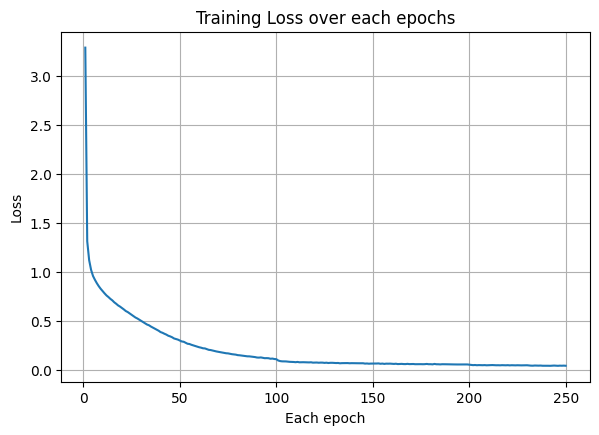

In [19]:
%matplotlib inline
plt.figure(figsize=(15, 10))
train_losses = [round(num, 5) for num in train_losses]
plt.subplot(2, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, linestyle='-',label='Training Loss')
#plt.plot(range(1, len(test_losses) + 1), test_losses, linestyle='-', color='orange', label='Test Loss')
plt.xlabel('Each epoch')
plt.ylabel('Loss')
plt.title('Training Loss over each epochs')
plt.grid()

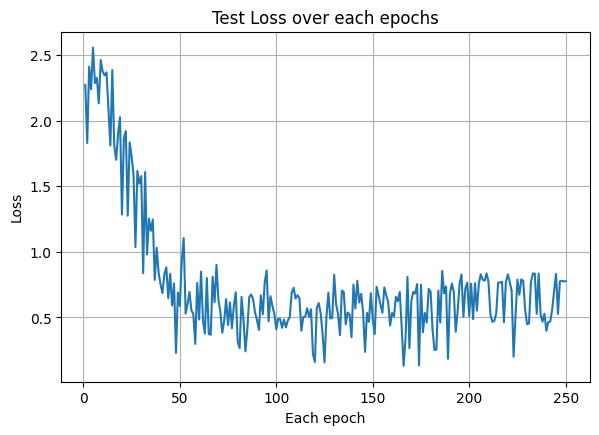

In [20]:
%matplotlib inline
plt.figure(figsize=(15, 10))
train_losses = [round(num, 5) for num in test_losses]
plt.subplot(2, 2, 1)
plt.plot(range(1, len(test_losses) + 1), test_losses, linestyle='-',label='Training Loss')
#plt.plot(range(1, len(test_losses) + 1), test_losses, linestyle='-', color='orange', label='Test Loss')
plt.xlabel('Each epoch')
plt.ylabel('Loss')
plt.title('Test Loss over each epochs')
plt.grid()

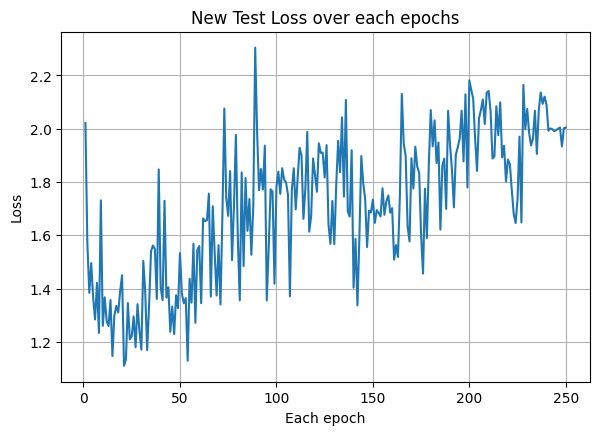

In [21]:
%matplotlib inline
plt.figure(figsize=(15, 10))
train_losses = [round(num, 5) for num in n_test_losses]
plt.subplot(2, 2, 1)
plt.plot(range(1, len(n_test_losses) + 1), n_test_losses, linestyle='-',label='Training Loss')
#plt.plot(range(1, len(test_losses) + 1), test_losses, linestyle='-', color='orange', label='Test Loss')
plt.xlabel('Each epoch')
plt.ylabel('Loss')
plt.title('New Test Loss over each epochs')
plt.grid()

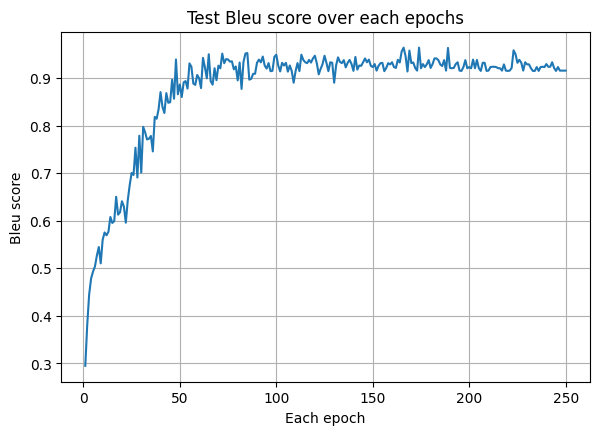

In [22]:
%matplotlib inline
plt.figure(figsize=(15, 10))
train_losses = [round(num, 5) for num in  test_bleus]
plt.subplot(2, 2, 1)
plt.plot(range(1, len(test_bleus) + 1), test_bleus, linestyle='-',label='Training Loss')
plt.xlabel('Each epoch')
plt.ylabel('Bleu score')
plt.title('Test Bleu score over each epochs')
plt.grid()

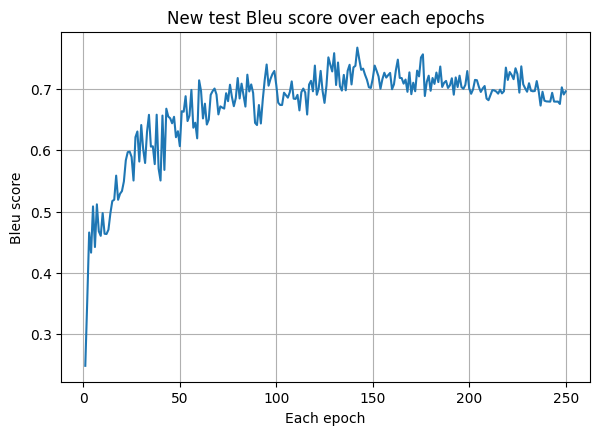

In [23]:
%matplotlib inline
plt.figure(figsize=(15, 10))
train_losses = [round(num, 5) for num in  n_test_bleus]
plt.subplot(2, 2, 1)
plt.plot(range(1, len(n_test_bleus) + 1), n_test_bleus, linestyle='-',label='Training Loss')
plt.xlabel('Each epoch')
plt.ylabel('Bleu score')
plt.title('New test Bleu score over each epochs')
plt.grid()

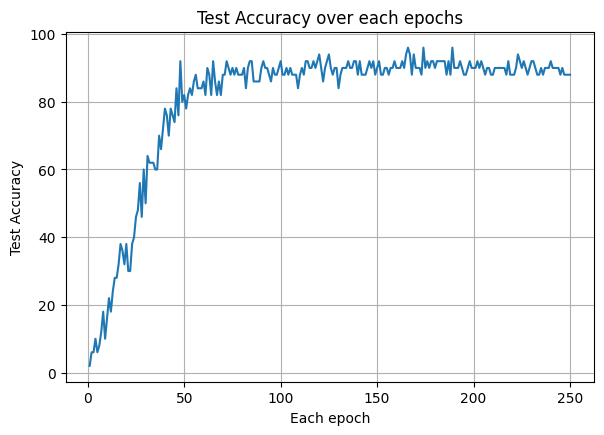

In [24]:
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, len(test_accs) + 1), test_accs, linestyle='-',label='Test Accuracy')
plt.xlabel('Each epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over each epochs')
plt.grid()

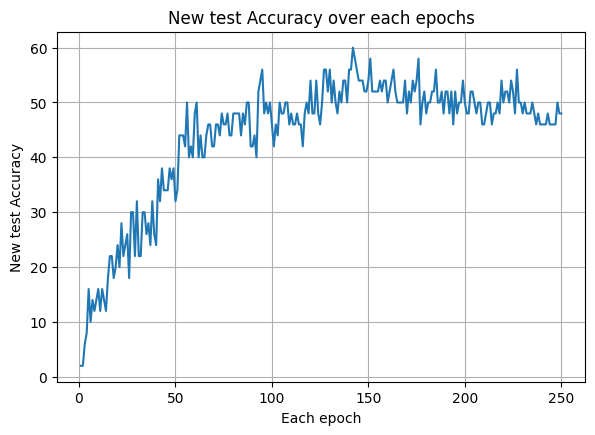

In [25]:
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, len(n_test_accs) + 1), n_test_accs, linestyle='-',label='New test Accuracy')
plt.xlabel('Each epoch')
plt.ylabel('New test Accuracy')
plt.title('New test Accuracy over each epochs')
plt.grid()

In [26]:
validation(testloader, model, device, logout=True)

input: apreciate
pred: appreciate
target: appreciate
input: appeciate
pred: appreciate
target: appreciate
input: apprciate
pred: approximate
target: appreciate
input: apprecate
pred: appreciate
target: appreciate
input: apprecite
pred: apprecite
target: appreciate
input: luve
pred: love
target: love
input: culd
pred: could
target: cold
input: heart
pred: heart
target: heart
input: televiseon
pred: television
target: television
input: thone
pred: phone
target: phone
input: phace
pred: phace
target: phase
input: poam
pred: poem
target: poem
input: tomorraw
pred: tomorraw
target: tomorrow
input: presishan
pred: precishen
target: precision
input: presishion
pred: precision
target: precision
input: presisian
pred: precisian
target: precision
input: presistion
pred: precision
target: precision
input: perver
pred: priver
target: prefer
input: predgudice
pred: preguadic
target: prejudice
input: predgudis
pred: preguadis
target: prejudice
input: recievor
pred: receiver
target: receiver
input: r

(48.0, 2.004458025093527, 0.6960988062865048)

In [27]:
validation2(valloader, model, device, logout=True)

input: contenpted
pred: contented
target: contented
input: begining
pred: looking
target: beginning
input: problam
pred: problem
target: problem
input: dirven
pred: driven
target: driven
input: ecstacy
pred: ecstasy
target: ecstasy
input: juce
pred: juice
target: juice
input: localy
pred: locally
target: locally
input: compair
pred: compare
target: compare
input: pronounciation
pred: pronunciation
target: pronunciation
input: transportibility
pred: transportability
target: transportability
input: miniscule
pred: minuscule
target: minuscule
input: independant
pred: independent
target: independent
input: aranged
pred: arranged
target: arranged
input: poartry
pred: portory
target: poetry
input: leval
pred: level
target: level
input: basicaly
pred: basically
target: basically
input: triangulaur
pred: triangular
target: triangular
input: unexpcted
pred: unexpected
target: unexpected
input: stanerdizing
pred: standardizing
target: standardizing
input: varable
pred: variable
target: variable


(88.0, 0.7759272424373194, 0.9156983856623281)